# Optimización de redes neuronales a través de algoritmos genéticos


En este notebook se llevará a cabo la optimización de los hiperparámetros de una red neuronal mediante el uso de algoritmos genéticos.

La función de nuestra red neuronal es la predicción del PH del agua a través de ciertos parámetros

1. Cargamos las bibliotecas necesarias

In [6]:
!pip install deap

In [29]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from deap import base, creator, tools, algorithms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

Cargamos el dataset

In [3]:
path = 'https://raw.githubusercontent.com/Yahred/evolutionary-computation/main/data/PARAMETROS_FINALES_CRUDOS.csv'

df = pd.read_csv(path)
ph = 'pH_CAMPO'

In [4]:
df.head()

,CLOROF_A,COLI_FEC,COLI_TOT,E_COLI,COT,COT_SOL,DBO_SOL,DBO_TOT,DQO_SOL,DQO_TOT,...,TURBIEDAD,TEMP_AMB,PROFUNDIDAD,CAUDAL,DUR_TOT,TEMP_AGUA,CONDUC_CAMPO,pH_CAMPO,OD_%,OD_mg/L
0,NaN,24196.0,24196.0,NaN,2.3560,2.3500,3.33,6.63,12.6,18.0872,...,46.0,35.3,NaN,430.0,303.3400,24.6,1200.0,8.20,83.7,5.26
1,NaN,24196.0,24196.0,24196.0,8.3441,6.4727,2.73,4.11,15.5,27.8784,...,60.0,26.7,NaN,420000.0,222.9984,24.3,677.0,7.97,85.8,7.21
2,NaN,24196.0,24196.0,3654.0,8.1953,6.1425,4.97,6.65,10.0,16.1600,...,30.0,34.6,NaN,180.0,224.4432,25.8,479.0,8.02,89.8,7.31
3,NaN,24196.0,24196.0,776.0,7.6502,4.0415,2.00,2.34,10.0,10.0000,...,40.0,NaN,NaN,5.0,414.9600,29.9,930.0,8.05,94.3,7.07
4,NaN,663.0,12997.0,109.0,9.4452,3.0909,2.00,2.33,10.0,25.4700,...,5.5,37.4,NaN,5.0,298.9900,33.1,1170.0,8.27,127.6,9.06


# 1. Limpieza de datos


Removemos las filas con valores nulos de pH_CAMPO, debido a que es el valor que queremos predecir

In [5]:
df.shape

(6162, 34)

In [6]:
df = df.dropna(subset=[ph])

In [7]:
df.shape

(6067, 34)

Removemos las columnas que no cuentan con al menos el 95% de registros

In [8]:
rows = len(df)
umbral = 0.95 * rows

df = df.dropna(thresh=umbral, axis=1)

In [9]:
df.shape

(6067, 22)

Nos quedan 22 columnas, ahora para el resto de datos nulos realizaremos una estrategia de imputación con mediana

In [10]:
columnas = list(df.columns)

df_imputado = df.copy()
for col in columnas:
  print(col, df[col].median())
  df_imputado[col].fillna(df[col].median(), inplace=True)

df = df_imputado

COLI_FEC 1723.0
COT 3.303
COT_SOL 2.7924499999999997
N_NH3 0.100493
N_NO2 0.005804999999999999
N_NO3 0.079
N_ORG 0.6272249999999999
N_TOT 1.1867450000000002
N_TOTK 0.795853
P_TOT 0.12009500000000001
ORTO_PO4 0.042891
COLOR_VER 18.0
ABS_UV 0.0874
SDT 481.92
SST 23.0
TURBIEDAD 7.5
TEMP_AMB 31.0
TEMP_AGUA 29.1
CONDUC_CAMPO 775.0
pH_CAMPO 8.1
OD_% 95.9
OD_mg/L 7.3


In [11]:
df.head()

,COLI_FEC,COT,COT_SOL,N_NH3,N_NO2,N_NO3,N_ORG,N_TOT,N_TOTK,P_TOT,...,ABS_UV,SDT,SST,TURBIEDAD,TEMP_AMB,TEMP_AGUA,CONDUC_CAMPO,pH_CAMPO,OD_%,OD_mg/L
0,24196.0,2.3560,2.3500,0.0030,0.0341,19.6195,0.0000,19.6566,0.0030,0.2080,...,0.0090,768.00,76.6667,46.0,35.3,24.6,1200.0,8.20,83.7,5.26
1,24196.0,8.3441,6.4727,0.2566,0.0603,33.4269,0.0000,33.7438,0.2566,0.2475,...,0.0288,433.28,43.0000,60.0,26.7,24.3,677.0,7.97,85.8,7.21
2,24196.0,8.1953,6.1425,0.1063,0.0279,8.0885,0.0781,8.3008,0.1844,0.1814,...,0.0086,306.56,45.6250,30.0,34.6,25.8,479.0,8.02,89.8,7.31
3,24196.0,7.6502,4.0415,0.2231,0.0354,16.7725,0.0000,17.0310,0.2231,0.1451,...,0.0090,595.20,54.0000,40.0,31.0,29.9,930.0,8.05,94.3,7.07
4,663.0,9.4452,3.0909,0.0589,0.0601,14.5449,0.0000,14.6639,0.0589,0.1387,...,0.0935,748.80,30.0000,5.5,37.4,33.1,1170.0,8.27,127.6,9.06


Ahora los datos está listos nuestro dataset esta listo y podemos definir los datos de entrenamiento y los datos de validación.

In [33]:
X = df.drop(ph, axis=1)

scaler = MinMaxScaler()

X = scaler.fit_transform(X)
y = scaler.fit_transform(df[ph].values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Definición del algoritmo evolutivo

Los hiperparámetros que vamos a evolucionar (listados respecto a la posición del gen que los representa dentro del genotipo) serán:


*  hidden_layer_sizes
*  activation
*  solver
*  alpha
*  learning_rate
*  max_iter


In [34]:
opciones_genes = {
  'hidden_layer_sizes': [(128, 64, 32), (64, 32), (32)],
  'activation': ['identity', 'logistic', 'tanh', 'relu'],
  'solver': ['lbfgs', 'sgd', 'adam'],
  'alpha': (0.0001, 0.1),
  'learning_rate': ['constant', 'invscaling', 'adaptive'],
  'max_iter': (50, 250)
}

Definición de las caracetísticas del individuo


In [35]:
def crear_gen(hiper_parametro, valores):
  if isinstance(valores, tuple):
    inicio, fin = valores
    if isinstance(inicio, float) or isinstance(fin, float):
      return random.uniform(inicio, fin)
    if isinstance(inicio, int) or isinstance(fin, int):
      return random.randint(inicio, fin)
  if isinstance(valores, list):
    return random.randint(0, len(valores) - 1)

def crear_individuo():
    return [crear_gen(hiper_parametro, valores) for [hiper_parametro, valores] in opciones_genes.items()]

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, crear_individuo)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

ind = toolbox.individual()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [24]:
ind

[1, 3, 0, 0.09815506901265555, 0, 237]

Definiremos una función que nos ayude a pasar de la codificación del genotipo a los valores que en realidad necesitamos

In [36]:
def from_ind_to_hiper_param(ind):
    hiper_parametros = {}
    for index, [hiper_parametro, valor] in enumerate(opciones_genes.items()):
      gen = ind[index]
      if isinstance(opciones_genes[hiper_parametro], tuple):
        hiper_parametros[hiper_parametro] = gen
        continue
      hiper_parametros[hiper_parametro] = opciones_genes[hiper_parametro][gen]
    return hiper_parametros

# Definición de la evaluación de aptitud

Para esto se llevará a cabo el entramiento de un MLP con los hiperparámetros definidos por el individuo.

In [37]:
def fitness(ind):
  hiper_parametros = from_ind_to_hiper_param(ind)
  modelo = MLPRegressor(random_state=42, verbose=False, **hiper_parametros)
  modelo.fit(X_train, y_train)
  y_pred = modelo.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  return mse,

# Definición de la evolución

In [38]:
generaciones = 30
tamaño_poblacion = 10
longitud_cromosoma = 5
tamaño_torneo = 3
poblacion = []


toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=tamaño_torneo)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)

# Ejecución de la evolución

In [39]:
random.seed(64)

pop = toolbox.population(n=tamaño_poblacion)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, halloffame=hof, verbose=True, stats=stats)

ganador = tools.selBest(pop, k=1)[0]

gen	nevals	avg       
0  	10    	0.00174905
1  	6     	0.00156668
2  	6     	0.0015542 
3  	8     	0.00154502
4  	7     	0.00153448
5  	8     	0.00153393
6  	7     	0.00153393
7  	5     	0.00153393
8  	8     	0.00153867
9  	6     	0.00153393
10 	7     	0.00153393
11 	7     	0.00153393
12 	3     	0.00153868
13 	3     	0.00153393
14 	4     	0.00153393
15 	4     	0.00153393
16 	6     	0.00153393
17 	5     	0.00153448
18 	6     	0.00153393
19 	7     	0.00153393
20 	3     	0.00153393
21 	9     	0.00153393
22 	8     	0.00153393
23 	9     	0.00212078
24 	2     	0.00153393
25 	4     	0.00153393
26 	4     	0.00153393
27 	2     	0.00153393
28 	6     	0.00153393
29 	5     	0.00212553
30 	3     	0.00212078
31 	7     	0.00153393
32 	6     	0.00153393
33 	6     	0.00153868
34 	6     	0.00153393
35 	10    	0.00212078
36 	6     	0.00153393
37 	2     	0.00153393
38 	3     	0.00272853
39 	6     	0.00153393
40 	6     	0.00153393


In [41]:
ganador

[2, 0, 0, 0.04035325967951515, 0, 66]

In [42]:
ganador = from_ind_to_hiper_param(ind)

Imprimimos el individuo ganador

In [43]:
ganador

{'hidden_layer_sizes': (64, 32),
 'activation': 'tanh',
 'solver': 'lbfgs',
 'alpha': 0.02054117703400117,
 'learning_rate': 'constant',
 'max_iter': 136}

# 3. Creación del modelo


> Se crea el modelo final utilizado al individuo ganador



In [45]:
modelo = MLPRegressor(random_state=42, verbose=True, **ganador)
modelo.fit(X_train, y_train)

MLPRegressor(activation='tanh', alpha=0.02054117703400117,
             hidden_layer_sizes=(64, 32), max_iter=136, random_state=42,
             solver='lbfgs', verbose=True)

# 4. Evaluación del modelo

Imprimimos el MSE del modelo

In [46]:
y_pred = modelo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [47]:
mse

0.0016635741656423693

Graficamos las predicciones de prueba contra los datos reales


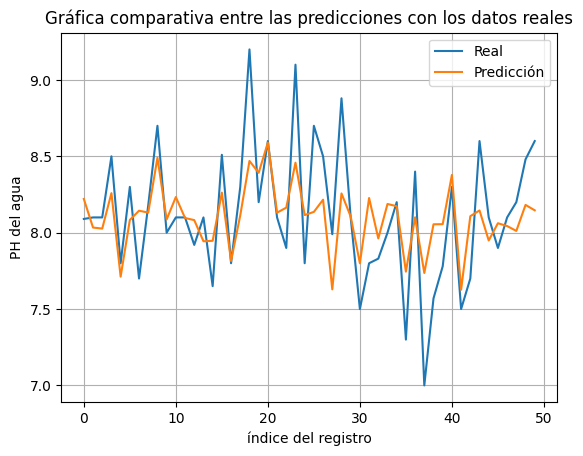

In [61]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

total_puntos = 50

x = range(0, total_puntos)
y = y_test[0 : total_puntos]

plt.plot(x, y, label='Real')

y = y_pred[0 : total_puntos]

plt.plot(x, y, label='Predicción')
plt.xlabel('índice del registro')
plt.ylabel('PH del agua')
plt.title('Gráfica comparativa entre las predicciones con los datos reales')
plt.legend()
plt.grid(True)
plt.show()